In [7]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import colorsys

import os
import re
import django
import logging

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [8]:
# Paths for JDBC driver and output
base_dir = os.path.join(os.path.expanduser('~'), 'git', 'light_site')
jdbc_dir = os.path.join(base_dir, "jbdc")
output_path = os.path.join(jdbc_dir, "output.parquet")
postgres_jar = "/opt/spark/jars/postgresql-42.7.4.jar"
# Initialize Spark Session with the JDBC driver included
spark = SparkSession.builder \
    .appName("PySpark JDBC Job") \
    .config("spark.jars", postgres_jar) \
    .getOrCreate()

# Logging setup
logging.basicConfig(level=logging.INFO)

def read_from_database():
    try:
        # JDBC connection properties
        jdbc_url = "jdbc:postgresql://localhost:5432/job_applications"
        connection_properties = {
            "user": "postgres",
            "password": "password",
            "driver": "org.postgresql.Driver"
        }

        # Reading data from PostgreSQL using JDBC
        df = spark.read.jdbc(url=jdbc_url, table="project_structure_projectentity", properties=connection_properties)

        # Show the loaded DataFrame
        df.show()

        # Count the number of rows and columns
        num_rows = df.count()
        num_columns = len(df.columns)

        logging.info(f"DataFrame shape: ({num_rows}, {num_columns})")

        # Optionally write the DataFrame to another location (e.g., Parquet format)
        df.write.parquet(output_path, mode="overwrite")

        logging.info("Data successfully loaded and processed.")
        
        return df  # Return the DataFrame

    except Exception as e:
        logging.error(f"Error reading from the database: {str(e)}")
        raise

# Execute the function and capture the DataFrame
df = read_from_database()

# Now you can convert the Spark DataFrame to a Pandas DataFrame
if df is not None:
    pandas_df = df.toPandas()
    logging.info("Converted to Pandas DataFrame")
else:
    logging.info("DataFrame is None, cannot convert to Pandas.")


+---+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+----------------+---------------------+-----------------+------------------+--------------+-----------+----------+--------------------+-----------------+--------------------+
| id|           directory|            filename|           full_path|file_size|metadata_change_time|   modification_time|         access_time|file_age_in_days|meta_data_age_in_days|recently_accessed|file_size_category|file_extension|python_file|file_depth| django_element_type|expected_location|      hover_template|
+---+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+----------------+---------------------+-----------------+------------------+--------------+-----------+----------+--------------------+-----------------+--------------------+
|  1|/home/tron/git/li...|                .env|/home

INFO:root:DataFrame shape: (1953, 18)
INFO:root:Data successfully loaded and processed.                               
INFO:root:Converted to Pandas DataFrame


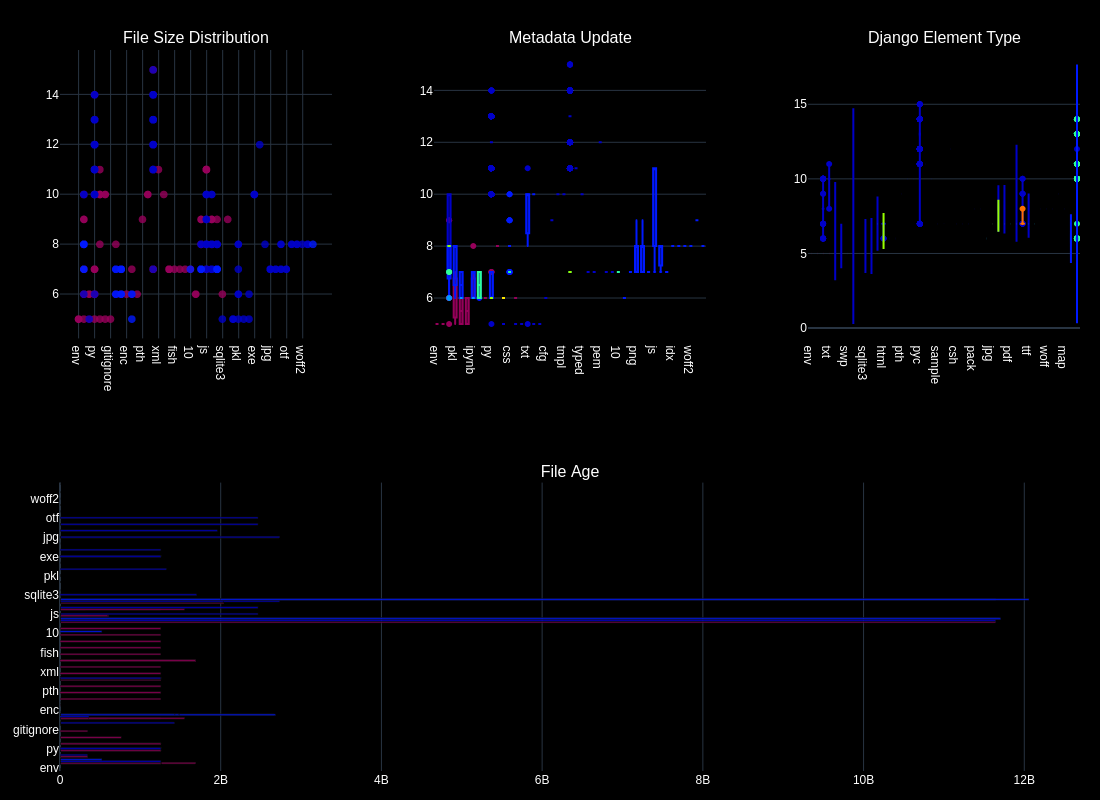

In [12]:
def create_django_project_analysis_plot(pandas_df):
    # Create a 2x3 subplot grid
    fig = make_subplots(
        rows=2, cols=3, 
        specs=[[{"colspan": 1}, {}, {}], [{"colspan": 3}, None, None]],  # Top row has 3 plots, bottom row has 1 plot stretched
        subplot_titles=("File Size Distribution", "Metadata Update", 
                        "Django Element Type", "File Age"),
        horizontal_spacing=0.1,
        vertical_spacing=0.2
    )

    # Graph A: Scatter Chart
    fig_a = px.scatter(
        pandas_df, 
        x='file_extension', 
        y='file_depth', 
        color='file_size_category', 
        size='file_depth',
        labels={'file_extension': 'File Extension', 'file_depth': 'File Depth'}, 
        template='plotly_dark',
        color_discrete_sequence=px.colors.sequential.Rainbow
    )
    fig_a.update_traces(marker=dict(size=8, opacity=0.8), showlegend=False)  # Consistent marker size and opacity
    for trace in fig_a.data:
        fig.add_trace(trace, row=1, col=1)

    # Graph B: Box Plot
    fig_b = px.box(
        pandas_df, 
        x='file_extension', 
        y='file_depth', 
        color='meta_data_age_in_days',
        labels={'file_extension': 'File Extension', 'file_depth': 'File Depth'}, 
        template='plotly_dark',
        color_discrete_sequence=px.colors.sequential.Rainbow
    )
    fig_b.update_traces(showlegend=False)
    for trace in fig_b.data:
        fig.add_trace(trace, row=1, col=2)

    # Graph C: Violin Plot
    fig_c = px.violin(
        pandas_df, 
        x='file_extension', 
        y='file_depth', 
        color='django_element_type',
        labels={'file_extension': 'File Extension', 'file_depth': 'File Depth'}, 
        template='plotly_dark',
        color_discrete_sequence=px.colors.sequential.Rainbow
    )
    fig_c.update_traces(showlegend=False)
    for trace in fig_c.data:
        fig.add_trace(trace, row=1, col=3)

    # Graph D: Scatter Plot (spans the entire width at the base)
    fig_d = px.timeline(
        pandas_df, 
        x_start='modification_time', 
        x_end='metadata_change_time', 
        y='file_extension', 
        color='file_size_category',
        labels={'metadata_change_time': 'Metadata Change', 'access_time': 'Last Accessed'}, 
        template='plotly_dark',
        color_discrete_sequence=px.colors.sequential.Rainbow  # Consistent color scheme
    )
    fig_d.update_traces(showlegend=False, opacity=0.8)  # Consistent opacity for clarity
    for trace in fig_d.data:
        fig.add_trace(trace, row=2, col=1)

    # Update layout for the entire figure with black background
    fig.update_layout(
        #title="Django Project Analysis",
        template='plotly_dark',
        width=1200, height=800,
        plot_bgcolor='black',  # Plot background color
        paper_bgcolor='black',  # Entire figure background color
        font_color='white',  # Font color for text elements
        margin=dict(l=20, r=20, t=50, b=20)  # Adjust margins for better layout
    )

    return fig

create_django_project_analysis_plot(pandas_df)

In [10]:
def create_file_analysis_plot_b(pandas_df):
    # Create a 2x3 subplot grid
    fig = make_subplots(
        rows=2, cols=3, 
        specs=[[{}, {}, {}], [{"colspan": 3}, None, None]],  # Top row has 3 plots, bottom row has 1 plot stretched
        subplot_titles=(
            "Directory Distribution", 
            "File Depth Distribution", 
            "File Extension Distribution",
            "Python File Distribution"
        ),
        horizontal_spacing=0.1,
        vertical_spacing=0.2
    )

    # Plot A: Directory Distribution (Bar Chart)
    pandas_df['short_directory'] = pandas_df['directory'].apply(lambda x: x[:20] + '...' if len(x) > 20 else x)
    fig_a = px.histogram(
        pandas_df, 
        x='short_directory', 
        color='file_size_category',
        labels={'short_directory': 'Directory'}, 
        template='plotly_dark', 
        color_discrete_sequence=['blue']
    )
    fig_a.update_traces(showlegend=False)

    # Extracting actual data for the line trace
    directory_counts = pandas_df['short_directory'].value_counts().reset_index()
    directory_counts.columns = ['short_directory', 'count']  # Renaming for clarity

    # Adding a line trace using actual data
    fig.add_scatter(
        x=directory_counts['short_directory'], 
        y=directory_counts['count'], 
        mode='lines', 
        line=dict(color='lightblue', width=2), 
        showlegend=False,
        row=1, col=1
    )

    for trace in fig_a['data']:
        fig.add_trace(trace, row=1, col=1)

    # Plot B: File Depth Distribution (Box Plot)
    fig_b = px.box(
        pandas_df, 
        x='file_depth', 
        y='file_size_category',
        labels={'file_depth': 'File Depth'}, 
        template='plotly_dark', 
        color_discrete_sequence=['blue']
    )
    fig_b.update_traces(showlegend=False)

    for trace in fig_b['data']:
        fig.add_trace(trace, row=1, col=2)

    # Plot C: File Extension Distribution (Violin Plot)
    fig_c = px.violin(
        pandas_df, 
        x='file_extension', 
        y='file_size',
        labels={'file_extension': 'File Extension', 'file_size': 'File Size'}, 
        template='plotly_dark', 
        color_discrete_sequence=['blue']
    )
    fig_c.update_traces(showlegend=False)

    for trace in fig_c['data']:
        fig.add_trace(trace, row=1, col=3)

    # Plot D: Python File Distribution (Bar Chart that spans the bottom row)
    fig_d = px.histogram(
        pandas_df, 
        x='python_file', 
        color='file_size_category',
        labels={'python_file': 'Is Python File'}, 
        template='plotly_dark', 
        color_discrete_sequence=['blue']
    )
    fig_d.update_traces(showlegend=True)

    # Extracting actual data for the line trace in the histogram for Python file distribution
    python_file_counts = pandas_df['python_file'].value_counts().reset_index()
    python_file_counts.columns = ['python_file', 'count']  # Renaming for clarity

    # Adding a line trace using actual data
    fig.add_scatter(
        x=python_file_counts['python_file'], 
        y=python_file_counts['count'], 
        mode='markers', 
        line=dict(color='lightblue', width=2), 
        showlegend=False,
        row=2, col=1
    )

    for trace in fig_d['data']:
        fig.add_trace(trace, row=2, col=1)

    # Update layout for the entire figure
    fig.update_layout(
        title="File System Analysis",
        template='plotly_dark',
        width=1200, height=800,
        plot_bgcolor='black',  # Plot background color
        paper_bgcolor='black',  # Entire figure background color
        font_color='white'  # Font color for text elements
    )

    return fig

create_file_analysis_plot_b(pandas_df)